# IPython Notebooks y Programación Científica con NumPy
### by Martín Villanueva, martin.villanueva@alumnos.usm.cl

## Introduction to IPython Notebooks

* In-browser editing for code, with automatic syntax highlighting, indentation, and tab completion/introspection.
* The ability to execute code from the browser, with the results of computations attached to the code which generated them. **It follows the cells paradigm, equals as Mathematica does.**
* Displaying the result of computation using rich media representations, such as HTML, LaTeX, PNG, SVG, etc. For example, publication-quality figures rendered by the **matplotlib** library, can be included inline.
* The ability to easily include mathematical notation within markdown cells using LaTeX, and rendered natively by MathJax.


### LaTeX integration

LaTeX has native suport in notebooks through *mathjax* extension. So you can write math LaTeX code inside a *'markdown cell'* as usual:
$$
\min_{u} \mathcal{J}(u) = \min_{u} \int_{\Omega} (u-f)^2 + \alpha \cdot \Phi_1(|\nabla u|^2) \ d\Omega
$$

### Matplotlib integration

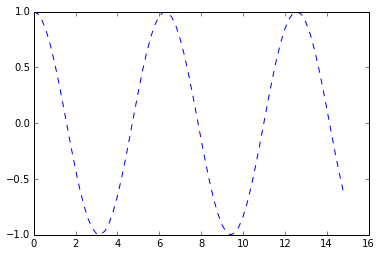

In [1]:
#Magic to plot matplotlib graphs in output cell (inside notebook)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0., 15., 0.2)
f = np.cos(t)
plt.plot(t, f, 'b--')
plt.show()

### Useful magic built-in functions for profiling

In [2]:
# install it with your favorite package manager, or with pip (if packages are not in a repository) 
# 'pip install line-profiler' and 'pip install memory_profiler'
%load_ext memory_profiler
%load_ext line_profiler

* **time**: See how long it takes a code to run.

In [3]:
%time {1+2 for i in range(10000)}

CPU times: user 829 µs, sys: 0 ns, total: 829 µs
Wall time: 831 µs


{3}


* **timeit**: See how long a code takes to run averaged over multiple runs.  It will limit the number of runs depending on how long the script takes to execute.  Provide an accurate time calculation by reducing the impact of startup or shutdown costs on the time calculation by executing the code repeatedly.

In [4]:
%timeit {1+2 for i in range(10000)}

1000 loops, best of 3: 590 µs per loop


In [5]:
%timeit -n 100 {1+2 for i in range(10000)}

100 loops, best of 3: 577 µs per loop


* **prun**: See how long it took each function in a script to run.

In [6]:
from time import sleep

def foo(): sleep(1)
    
def bar(): sleep(2)
    
def baz(): foo(),bar()

In [7]:
%prun baz()

* **lprun**: See how long it took each line in a function to run.

In [8]:
def test_func(n):
    a = np.random.random(n)
    b = np.random.random(n)
    c = np.dot(a,b)
    c.sum()
    return c

import test

In [9]:
%lprun -f test_func test_func(1000)

* **memit**: See how much memory a code uses overall. %memit works a lot like %timeit except that the number of iterations is set with -r instead of -n.

In [10]:
%memit -r 5 test.func1(10000)

peak memory: 61.45 MiB, increment: 0.35 MiB


## Introduction to NumPy

### Why Python is so slow?

* ** Python is Dynamically Typed rather than Statically Typed.** What this means is that at the time the program executes, the interpreter doesn't know the type of the variables that are defined. <img src='cint_vs_pyint.png' style="width: 300px;">
* **Python is interpreted rather than compiled.** A smart compiler can look ahead and optimize for repeated or unneeded operations, which can result in speed-ups. 
* **Python's object model can lead to inefficient memory access.** A NumPy array in its simplest form is a Python object build around a C array. That is, it has a pointer to a contiguous data buffer of values. A Python list, on the other hand, has a pointer to a contiguous buffer of pointers, each of which points to a Python object which in turn has references to its data (in this case, integers). <img src='array_vs_list.png' style="width: 500px;">

### Why Numpy is so fast?

* Computations follow the **Single Instruction Multiple Data** (SIMD) paradigm. So that NumPy can take advantage of vectorized instructions on modern CPUs, like Intel's SSE and AVX, AMD's XOP.
<img src='devectorized.png' style="width: 350px;", caption='asdf'>
<img src='vectorized.png' style="width: 350px;">
* A NumPy array is described by metadata (number of dimensions, shape, data type, strides, and so on) and the data (which is stored in a **homogeneous and contiguous** blocks of memory).
* **Array computations** can be written very efficiently in a low-level language like C (and a large part of NumPy is actually written in C). Aditionally many internal methods and functions are linked to highly optimized linear algebra libraries like **BLAS** (Basic Linear Algebra Subprograms) and **LAPACK** (Linear Algebra PACKage).
* **Spatial locality** in memory access patterns results in significant performance gains, notably thanks to the CPU cache.  Indeed, the cache loads bytes in chunks from RAM to the CPU registers.

## Lets see the problem...

Consider the problem of calculating the squared norm of a vector with the following 4 implementations.

In [11]:
#Python Lists implementation
def norm_square_list(vector):
    norm = 0
    for v in vector:
        norm += v*v
    return norm

#Naive NumPy implementation
def norm_square_array(vector):
    norm = 0
    for v in vector:
        norm += v*v
    return norm

#Vectorized NumPy implementation
def norm_square_numpy(vector):
    return np.sum(vector * vector)

#Clever NumPy implementation
def norm_square_dot(vector):
    return np.dot(vector, vector)

#Vector to use - dimension 10^6
vector = range(1000000)
npvector = np.array(vector)

In [12]:
#Timing the list implementation
%timeit norm_square_list(vector)

10 loops, best of 3: 91 ms per loop


In [13]:
#Timing the naive array implementation
%timeit norm_square_array(npvector)

1 loops, best of 3: 1.02 s per loop


In [14]:
#Timing the NumPy-vectorized implementation
%timeit norm_square_numpy(npvector)

100 loops, best of 3: 5.47 ms per loop


In [15]:
#Timing the clever NumPy-vectorized implementation
%timeit norm_square_dot(npvector)

1000 loops, best of 3: 1.46 ms per loop


As you can see, some interesting things have happened:
* The naive array implementation, which iterates over data is actually slower than simply using a list. This is because the *array* stores a  very low-level representation of the numbers it stores , and this **must be converted** into Python-compatible version before being returned to user, causing this extra overhead each time you index an *array*.
* *norm_square_numpy* is slower than the clever NumPy implementation because two reasons: 1) There is time spend in allocating memory for storing the temporary result *(vector x vector)* and 2) This creates two **implied loops**, one to do the multiplication and one to do the sum.
* The clever implementation uses *np.dot()* NumPy function which has no need to store intermediate results, and iterates just one time (but at C speed).

## Eficient programming with NumPy

### In-place and implicit copy operations

Prefer in-place over implicit-copy operations whenever possible. This will save memory (less work to garbage collector) and performs faster.

In [16]:
def id(x):
    # This function returns the memory
    # block address of an array.
    return x.__array_interface__['data'][0]

Array computations can involve **in-place** operations (first example below: the array is modified) or **implicit-copy** operations (second example: a new array is created).

In [17]:
a = np.zeros(10); aid = id(a)

In [18]:
# in-place operation
a *= 2; id(a) == aid

True

In [19]:
# implicit-copy operation
a = a * 2; id(a) == aid

False

Be sure to choose the type of operation you actually need. Implicit-copy operations are **slower!**

In [20]:
%%timeit 
a = np.ones(100000000)
a *= 2

1 loops, best of 3: 751 ms per loop


In [21]:
%%timeit
a = np.ones(100000000)
b = a * 2

1 loops, best of 3: 962 ms per loop


### Efficient memory access

Use **array slicing**, **masks** and **fancy indexing** (in this order) to eliminate loops. If you find yourself looping over indices to select items on which operation is performed, it can probably be done more efficiently with one of these techniques.

In [22]:
m, n = 1000000, 100
a = np.random.random_sample((m, n))
index = np.arange(0, m, 10)

In [23]:
#fancy indexing - indexing with lists
%timeit a[index]

1 loops, best of 3: 228 ms per loop


In [24]:
#memory slice - memory views
%timeit a[::10]

1000000 loops, best of 3: 1.45 µs per loop


*  Array slices are implemented as memory views, i.e, refer to the original data buffer of an array, but with different offsets, shapes and strides.
* Array views should be used whenever possible, but one needs to be careful about the fact that views refer to the original data buffer.
* Fancy indexing is several orders of magnitude slower as it involves copying a large array.

Another useful indexing technique is mask of booleans. Lets suppose we want to get all the elements on array with value less than 0.5

In [25]:
def naive_indexing(vect):
    ret = list()
    for val in vect:
        if val < 0.5: ret.append(val)
    return np.array(ret)

#data to occupy and mask of booleans
vect = np.random.random_sample(1000000)
mask = vect < 0.5
mask

array([ True,  True, False, ..., False, False,  True], dtype=bool)

In [26]:
#naive indexing
%timeit naive_indexing(vect)

1 loops, best of 3: 369 ms per loop


In [27]:
#mask indexing
%timeit vect[mask]

100 loops, best of 3: 9.35 ms per loop


In [28]:
#'improved' mask indexing
%timeit np.compress(mask, vect, axis=0)

100 loops, best of 3: 11.5 ms per loop


### Universal Functions

A powerful feature of Numpy is the concept of *ufunc* short for "universal function." These functions operate on every value of an array **without need of loops**. This must be used instead for iterating over the array (eliminate loops!) and computing over each single data element. 

In [29]:
# Arithmetic operations like +,-,*,/ are implemented as binary ufuncs
x = np.arange(10)
x*x #multiply each element of x by itself

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [30]:
# NumPy provides a lot of standar unary ufuncs
# np.sin, np.cos, np.tan, np.exp, np.log, np.sinh, np.cosh and so on.
np.sin(x) #take the sine of each element

array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
       -0.95892427, -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849])

### Broadcasting

There is no need to always reshape arrays before operate on them. This useful feature implemented in NumPy arrays is called **Broadcasting rules.** In the visualization below, the extra memory indicated by the dotted boxes is never allocated, but it can be convenient to think about the operations as if it is.
<img src='broadcasting.png' style="width: 400px;">


In [31]:
# array([0,1,2]) + 5
np.arange(3) + 5

array([5, 6, 7])

In [32]:
# array([[1, 1 ,1], [1, 1, 1], [1, 1, 1]]) + array([0, 1, 2])
np.ones((3,3)) + np.arange(3)

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [ 1.,  2.,  3.]])

In [33]:
# array([[0], [1], [2]]) + array([0, 1 ,2])
np.arange(3).reshape((3,1)) + np.arange(3)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

## Vectorized Algorithms with NumPy

**Vectorization:** *The process of converting a scalar implementation, which processes a single pair of operands at a time, to a vector implementation, which processes one operation on multiple pairs of operands at once.*

### Example: Gram-Shmidt Orthogonalization

**The problem**: Given a matrix $Q_{m\times n}$ with ($m>n$), find a vector $v$ orthogonal to the column space of $Q$. 
<img src='orthogonalization.jpg' style="width: 400px;">

In [34]:
def naive_orth(Q,v):
    m,n = Q.shape
    for j in range(n):
        v -= np.dot(Q[:,j],v)*Q[:,j]
    return v
    
def vectorized_orth(Q,v):
    proy = np.dot(Q.transpose(),v)
    # v -= (proy*Q).sum(axis=1)
    v -= np.dot(Q,proy)
    return v

In [35]:
# Let's generate a random unitary matrix
# Q unitary matrix, dimensions 100000 x1000
m,n = 10000,100
A = 10 * np.random.random((m,n))
Q,R = np.linalg.qr(A, mode='reduced')
del R

# v will be the starting vector for orthogonalization
v = np.random.random(m)
v1 = v.copy()
v2 = v.copy()

In [36]:
%timeit naive_orth(Q,v1)

100 loops, best of 3: 8.82 ms per loop


In [37]:
%timeit vectorized_orth(Q,v2)

100 loops, best of 3: 2.73 ms per loop


## The Limits of Vectorized Algorithms

Lets suppose we want to evaluate the complicated function $f(x,y) = e^{(x-y)^2 + (x+y)^2}\cdot(\cos{(x\ y)} + \sin{(x\ y)}- \cos{(x)}\sin{(y)})$ on a set of data points $\mathbf{x}=[x_0,\ldots,x_n]$ and $\mathbf{y}=[y_0,\ldots,y_n]$ in a vectorized way. The question is, ** what is the problem with vectorized algorithms?**
* It takes time to **allocate memory** for the temporary arrays (and many unnecessary temporaries are created).
* It takes time to reclaim the memory of these arrays during **garbage collection**.
* It takes time to **traverse the memory** – generally, computation on large arrays is often memory-bound – the run-time performance largely depends on how many times you have to scan the arrays.

In [38]:
def vec_func(x,y):
    return np.exp(np.sqrt((x-y)**2 + (x+y)**2))*(np.cos(x*y) + np.sin(x*y) - np.cos(x)*np.cos(y))

#devec is a dynamic module, written in Cython
import devec

A devectorized version of vec_func() was implemented with Cython as follows
<img src='devec_code.png' style="width: 700px;">

In [39]:
#random data to be used
x0 = 10 * np.random.random(10000000)
y0 = 10 * np.random.random(10000000)

In [40]:
#time of vectorized function
%timeit vec_func(x0,y0)

1 loops, best of 3: 4.33 s per loop


In [41]:
#memory of vectorized function
%memit vec_func(x0,y0)

peak memory: 1417.88 MiB, increment: 362.96 MiB


In [42]:
#time of devectorized function
%timeit devec.func(x0,y0)

1 loops, best of 3: 3.3 s per loop


In [43]:
#memory of devectorized function
%memit devec.func(x0,y0)

peak memory: 1130.54 MiB, increment: 75.52 MiB


** Warning :** By default, timeit() temporarily turns off garbage collection during the timing. The advantage of this approach is that it makes independent timings more comparable. This disadvantage is that GC may be an important component of the performance of the function being measured.

## Bonus: Useful libraries based in NumPy

### numpy.linalg (Numpy's submodule)

In [44]:
A = np.random.random((100,100))
b = np.random.random(100)
c = np.random.random(100)

### Matrix power ###
np.linalg.matrix_power(A,3)

### Cholesky decomposition ###
#np.linalg.cholesky(A) #A must be positive definite

### QR decomposition ###
np.linalg.qr(A, mode='reduced')

### SVD decomposition ###
np.linalg.svd(A, full_matrices=False)

### Eigenvectors ###
np.linalg.eig(A)

### Eigevalues ###
np.linalg.eigvals(A)

### Matrix or vector norm ###
np.linalg.norm(A, ord='fro')

### Condition number ###
np.linalg.cond(A, p=np.inf)

### Determinant ###
np.linalg.det(A)

### Linear solver Ax=b ###
np.linalg.solve(A,b)

### Least Squares Ax=b (over-determined) ###
np.linalg.lstsq(A,b)

### Inverse ###
np.linalg.inv(A)

### Pseudo-Inverse ###
np.linalg.pinv(A)

### and many more...
del A,b,c

### scipy.optimize(SciPy's submodule)

* bisect(f, a, b[, args, xtol, rtol, maxiter, ...]) -  	Find root of a function within an interval.
* newton(func, x0[, fprime, args, tol, ...]) -	Find a zero using the Newton-Raphson or secant method.
* fixed_point(func, x0[, args, xtol, maxiter]) -	Find a fixed point of the function.
* root(fun, x0[, args, method, jac, tol, ...]) -	Find a root of a vector function.
* fsolve(func, x0[, args, fprime, ...]) -	Find the roots of a function.

### scipy.integrate (Scipy's submodule)

* cumtrapz(y[, x, dx, axis, initial]) -	Cumulatively integrate y(x) using the composite trapezoidal rule.
* simps(y[, x, dx, axis, even]) -	Integrate y(x) using samples along the given axis and the composite Simpson’s rule.
* fixed_quad(func, a, b[, args, n]) -	Compute a definite integral using fixed-order Gaussian quadrature.
* quadrature(func, a, b[, args, tol, rtol, ...]) -	Compute a definite integral using fixed-tolerance Gaussian quadrature.
* odeint(func, y0, t[, args, Dfun, col_deriv, ...]) -	Integrate a system of ordinary differential equations.

## References

* [*IPython notebook oficial documentation*](http://ipython.readthedocs.org/en/stable/)
* [*Time and memory Profiling in IPython*](http://pynash.org/2013/03/06/timing-and-profiling.html)
* [*Getting the best performance out of NumPy*](http://ipython-books.github.io/featured-01/)
* [*Why Python is slow*](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)
* [*High Performance Python: Practical Performant Programming for Humans*](https://books.google.cl/books?id=bIZaBAAAQBAJ&pg=PA115&lpg=PA115&dq#v=onepage&q&f=false)